<a href="https://colab.research.google.com/github/EjbejaranosAI/AI_trends_2023/blob/main/MBM_AI_for__analysis_of_brain_image_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI/ML for the analysis of brain imaging data.
## MBM (Minds, brains and machines)
## Author: Edison Jair Bejarano Sepulveda

### Quantitative susceptibility mapping - QSM DATA from 2018 reconstruction challenge

##### *Download data*

In [1]:
# Downloading data
!wget -nc http://www.neuroimaging.at/media/qsm/20170327_qsm2016_recon_challenge.zip
!unzip -uo 20170327_qsm2016_recon_challenge.zip

File ‘20170327_qsm2016_recon_challenge.zip’ already there; not retrieving.

Archive:  20170327_qsm2016_recon_challenge.zip


##### *Libraries*

In [2]:
!pip install -q tensorflow==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-alpha0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.0.0-alpha0


In [3]:
# Importing libraries
import os
import pickle
import numpy as np
import nibabel as nib
from tqdm import tqdm
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import transforms

import tensorflow as tf
import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

##### *Utils functions*

In [4]:
# Utils functions

#--------------------------#
# Plot view slices brain 3D
#--------------------------#
def view_slices_3d(image_3d, slice_nbr, vmin, vmax, title=''):
    fig = plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(131)
    image = np.take(image_3d, slice_nbr, 2)
    plt.imshow(image, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Axial')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    plt.subplot(132)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 1),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Coronal')
    plt.xlabel('X-axis')
    plt.ylabel('Z-axis')
    
    plt.subplot(133)
    image_rot = ndimage.rotate(np.take(image_3d, slice_nbr, 0),90)
    plt.imshow(image_rot, vmin=vmin, vmax=vmax, cmap='gray')
    plt.title('Sagittal')
    plt.xlabel('Y-axis')
    plt.ylabel('Z-axis')
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Intensity', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

#--------------------------#
#       Random size 
#--------------------------#
def creating_random_size(min_size, max_size):
  random_size = np.random.randint(low = min_size, high = max_size)
  return random_size



#--------------------------#
# Susceptibility simulation
#--------------------------#
def simulate_susceptibility_sources(simulation_dim = 160,
                                    rectangles_total = 100, 
                                    spheres_total = 80, 
                                    sus_std = 1,
                                    shape_size_min_factor= 0.01,
                                    shape_size_max_factor = 0.5):
  
  temp_sources = np.zeros((simulation_dim, simulation_dim, simulation_dim))

  for shapes in range(rectangles_total):
    shrink_factor = 1/((shapes/rectangles_total+1))
    shape_size_min = np.floor(simulation_dim * shrink_factor * shape_size_min_factor)
    shape_size_max = np.floor(simulation_dim * shrink_factor * shape_size_max_factor)
    print(f"\n ------- Shape Min size: {shape_size_min} ------- \n")
    print(f"\n ------- Shape Max size: {shape_size_max} ------- \n")

    susceptibility_value = np.random.normal(loc=0.0, scale=sus_std)
    # Creating random sizes
    random_sizex = creating_random_size(shape_size_min,shape_size_max)
    random_sizey = creating_random_size(shape_size_min,shape_size_max)
    random_sizez = creating_random_size(shape_size_min,shape_size_max)
    # Getting axis positions
    x_pos = np.random.randint(simulation_dim)
    y_pos = np.random.randint(simulation_dim)
    z_pos = np.random.randint(simulation_dim)

    x_pos_max = x_pos + random_sizex
    if x_pos_max >= simulation_dim:
      x_pos_max = simulation_dim

    y_pos_max = y_pos + random_sizey
    if y_pos_max >= simulation_dim:
      y_pos_max = simulation_dim 

    z_pos_max = z_pos + random_sizez
    if z_pos_max >= simulation_dim:
      z_pos_max = simulation_dim

    temp_sources[x_pos:x_pos_max, y_pos:y_pos_max, z_pos:z_pos_max] = susceptibility_value

  return temp_sources

import numpy as np



#--------------------------#
#     Dipole kernel 3D
#--------------------------#
def create_dipole_kernel_3D(data_shape, voxel_size, b_vec):
    # Calculate the field of view
    fov = np.array(data_shape) * np.array(voxel_size)
    
    # Generate the x, y, and z coordinates of the image grid and
    # Create a meshgrid of the x, y, and z coordinates
    ry, rx, rz = np.meshgrid(np.arange(-data_shape[1] // 2, data_shape[1] // 2),
                          np.arange(-data_shape[0] // 2, data_shape[0] // 2),
                          np.arange(-data_shape[2] // 2, data_shape[2] // 2))
    
    # Normalize the x, y, and z coordinates by the field of view
    rx, ry, rz = rx / fov[0], ry / fov[1], rz / fov[2]
    
    # Calculate the squared distance from the origin
    sq_dist = rx ** 2 + ry ** 2 + rz ** 2
    sq_dist[sq_dist == 0] = 1e-6
    
    # Calculate the dipole kernel
    d2 = ((b_vec[0] * rx + b_vec[1] * ry + b_vec[2] * rz) ** 2) / sq_dist
    kernel = (1/3 - d2)
    
    return kernel


#--------------------------------------#
#   Forward convolution with padding
#--------------------------------------#
def simulate_mri_tissue_phase(sample, padding=20):
    # Pad the sample to avoid wrap-around at the edges
    padded_sample = np.pad(sample, pad_width=padding, mode='constant')

    # Scaling factor for Fourier transform normalization
    scaling = np.sqrt(padded_sample.size)
    
    # Perform Fourier transform of the padded sample
    sample_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(padded_sample))) / scaling

    # Generate a 3D dipole kernel
    dipole_kernel = create_dipole_kernel_3D(padded_sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    # Multiply the Fourier transform of the sample by the dipole kernel
    sample_fft_conv = sample_fft * dipole_kernel

    # Perform inverse Fourier transform and rescale by the scaling factor
    tissue_phase_unscaled = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(sample_fft_conv)))
    tissue_phase = np.real(tissue_phase_unscaled * scaling)

    # Crop the padded regions to match the original sample size
    tissue_phase_cropped = tissue_phase[padding:-padding, padding:-padding, padding:-padding]

    return tissue_phase_cropped


#--------------------------------------#
#     Forward convolution no padding
#--------------------------------------#
def simulate_mri_tissue_phase_no_padding(sample):
    # Scaling factor for Fourier transform normalization
    scaling = np.sqrt(sample.size)
    
    # Perform Fourier transform of the sample
    sample_fft = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(sample))) / scaling

    # Generate a 3D dipole kernel
    dipole_kernel = create_dipole_kernel_3D(sample.shape, voxel_size=1, b_vec=[0, 0, 1])

    # Multiply the Fourier transform of the sample by the dipole kernel
    sample_fft_conv = sample_fft * dipole_kernel

    # Perform inverse Fourier transform and rescale by the scaling factor
    tissue_phase = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(sample_fft_conv)))
    tissue_phase = np.real(tissue_phase * scaling)

    return tissue_phase


In [5]:
#--------------------------------------#
#     Creating batches for data
#--------------------------------------#
def create_batch(dimension, patch_idx, gt_full, fw_full):
    # Get the dimensions of the ground truth data
    x_max, y_max, z_max = gt_full.shape

    # Generate random indices for selecting the patch
    random_indices = np.random.choice(x_max - dimension, 3)
    randomX, randomY, randomZ = random_indices

    # Extract the patch using tuple indexing
    gt_patch = gt_full[randomX:randomX + dimension, randomY:randomY + dimension, randomZ:randomZ + dimension]
    fw_patch = fw_full[randomX:randomX + dimension, randomY:randomY + dimension, randomZ:randomZ + dimension]

    # Return the extracted patches
    return gt_patch, fw_patch

##### Images exploration by views

<ipython-input-6-b42306d4fe86>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
<ipython-input-6-b42306d4fe86>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


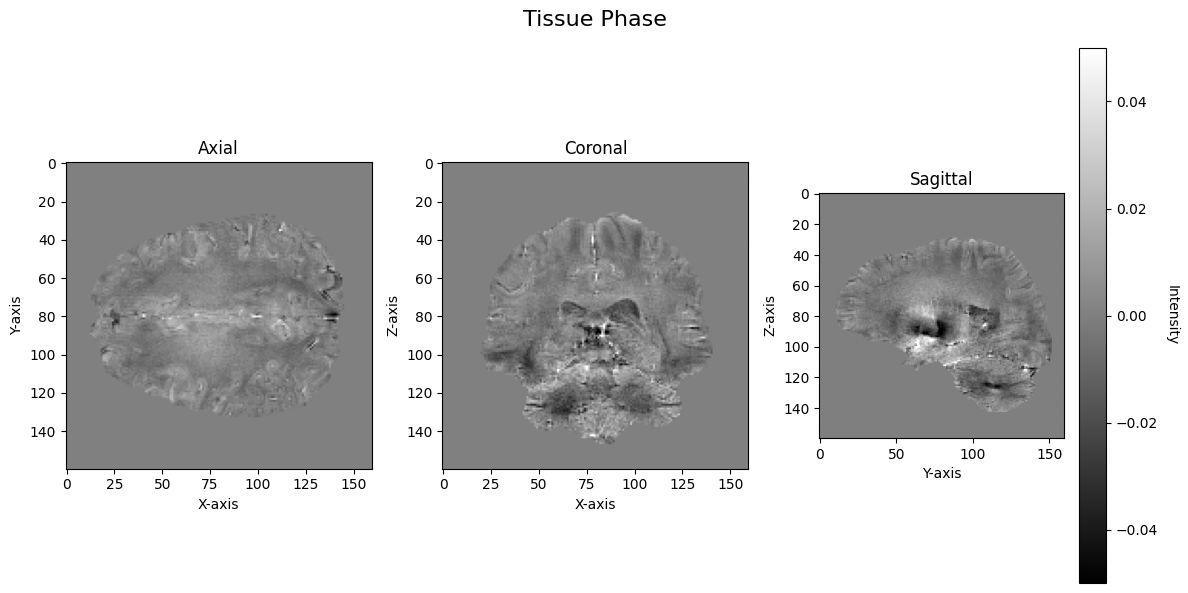

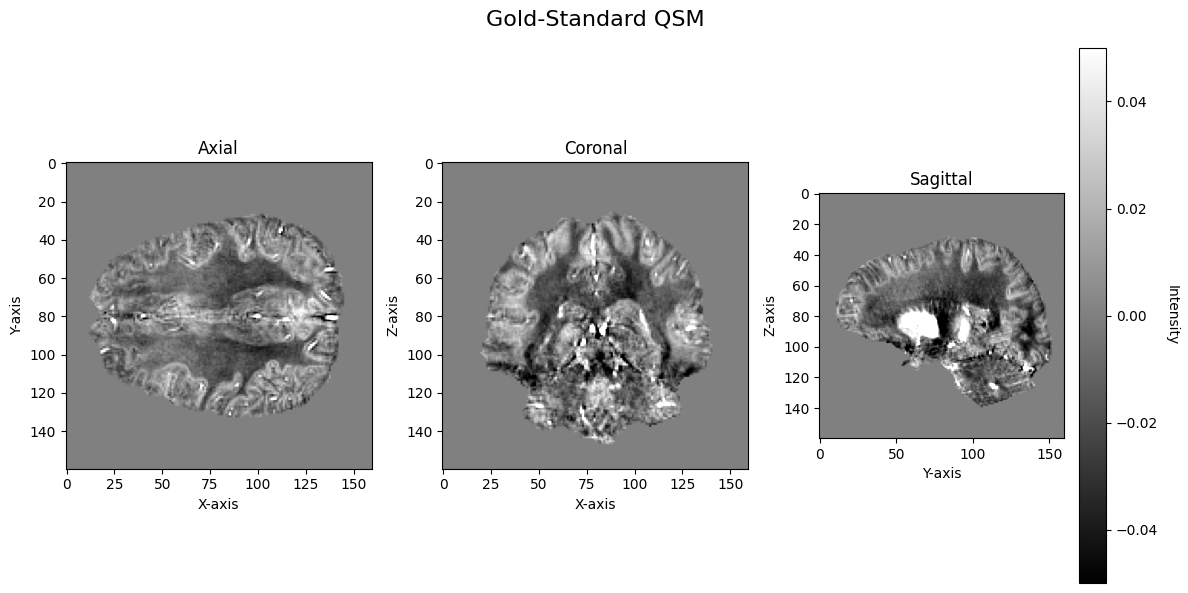

In [6]:
# Loading images by nib library
tissue_phase_brain = nib.load('/content/20170327_qsm2016_recon_challenge/data/phs_tissue.nii.gz').get_data()
gold_standard_qsm = nib.load('/content/20170327_qsm2016_recon_challenge/data/chi_33.nii.gz').get_data()


view_slices_3d(tissue_phase_brain, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Tissue Phase')
view_slices_3d(gold_standard_qsm, slice_nbr=100, vmin=-0.05, vmax=0.05, title='Gold-Standard QSM') 

##### *Simulation of susceptibility distribution*


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 160.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 159.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 158.0 ------- 


 ------- Shape Min size: 3.0 ------- 


 ------- Shape Max size: 157.0 ------- 


 ------- Shape 

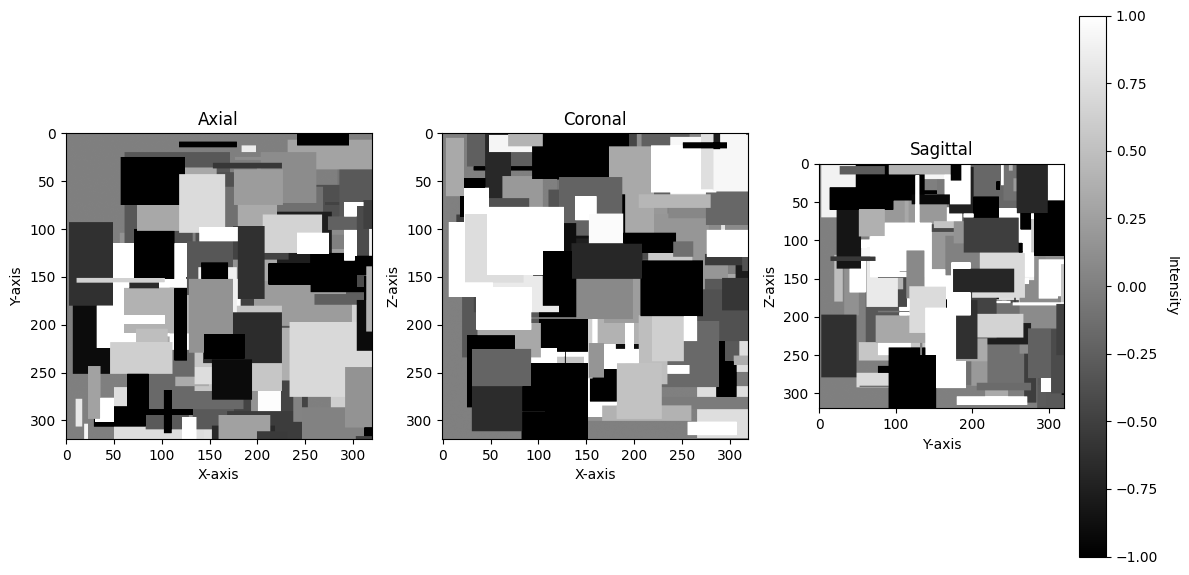

In [7]:
# sim_gt_full = simulated_ground_truth
sim_gt_full = simulate_susceptibility_sources(simulation_dim = 320, rectangles_total = 800, spheres_total = 80,)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

##### *Convolve susceptibility distribution with dipole kernel to yield tissue phase* 


Dipole Kernel: The code generates a 3D dipole kernel using the generate_3d_dipole_kernel function. This kernel represents the response of a magnetic dipole in a magnetic resonance imaging (MRI) system. It is used to model the interaction between the sample and the imaging system.

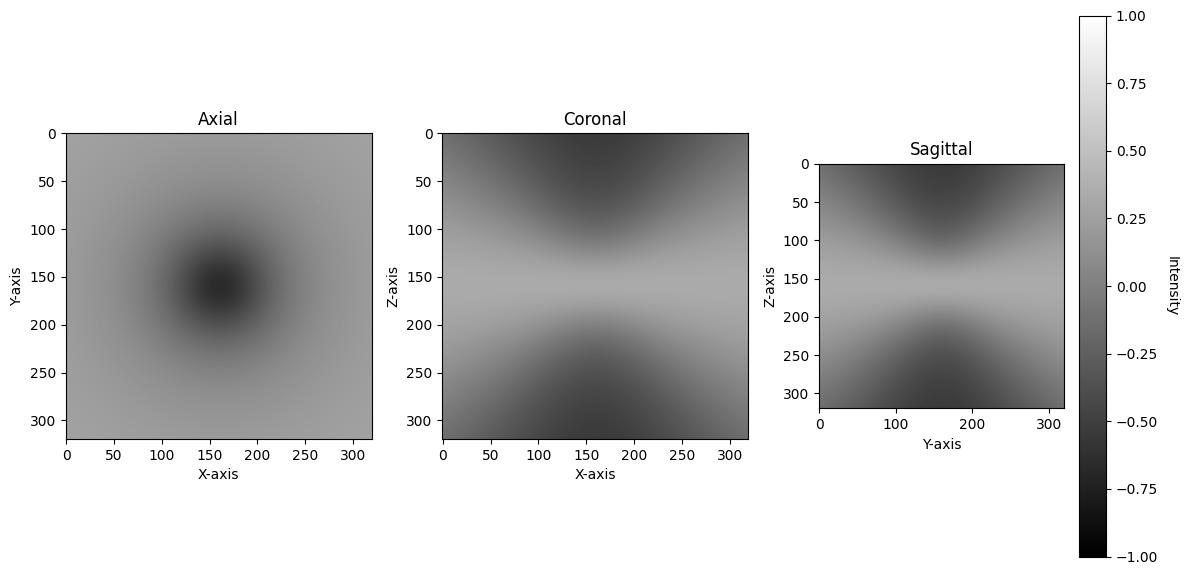

In [8]:
dipole_kernel3d = create_dipole_kernel_3D(sim_gt_full.shape, voxel_size=1, b_vec=[0, 0, 1])
view_slices_3d(dipole_kernel3d, slice_nbr=100, vmin=-1, vmax=1)

- **Fourier Transform:** The code uses the np.fft.fftn function to compute the N-dimensional Fast Fourier Transform (FFT) of the input sample. The np.fft.fftshift function is used to shift the zero-frequency component to the center of the spectrum. This is a common step in Fourier analysis to obtain a more intuitive representation of the data.

- **Inverse Fourier Transform:** The code uses the np.fft.ifftn function to compute the N-dimensional Inverse FFT (IFFT) of the transformed sample. Again, the np.fft.fftshift function is used to shift the zero-frequency component back to the corners of the spectrum.
Scaling: To ensure proper normalization, the code divides the transformed samples by the square root of the sample size (scaling). This step is necessary to preserve the total energy of the data during the Fourier transformations.



- **Multiplication and Convolution:** The code multiplies the transformed sample by the dipole kernel in the Fourier domain. This multiplication corresponds to a convolution operation in the spatial domain. By performing the multiplication in the Fourier domain, the code exploits the convolution theorem, which states that multiplication in the Fourier domain is equivalent to convolution in the spatial domain.

- **Inverse Transform and Rescaling:** After multiplying the transformed sample by the dipole kernel, the code applies the inverse Fourier transform to obtain the spatial representation of the result. The resulting tissue phase is then rescaled by the scaling factor to restore the proper amplitude of the data.

- **Padding and Cropping:** In the forward_convolution_padding function, the input sample is padded with zeros before the Fourier transform to avoid wrap-around artifacts at the edges. After the inverse transform, the padded regions are cropped to match the size of the original sample.

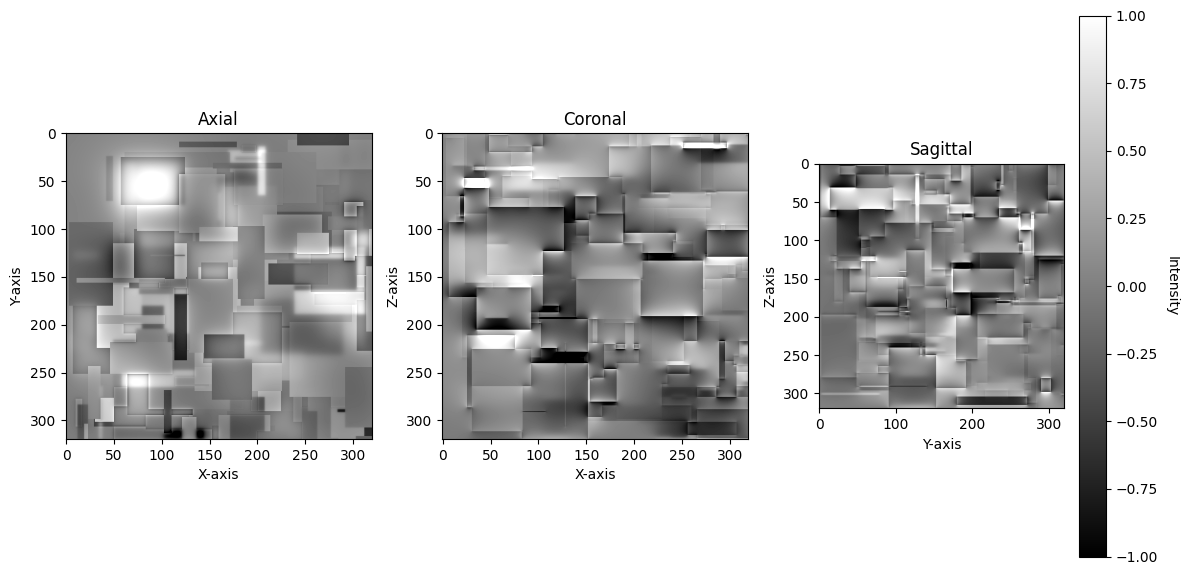

In [9]:
# Simulate tissue phase with padding
simulated_tissue_phase_full = simulate_mri_tissue_phase(sim_gt_full)
view_slices_3d(simulated_tissue_phase_full, slice_nbr=100, vmin=-1, vmax=1)

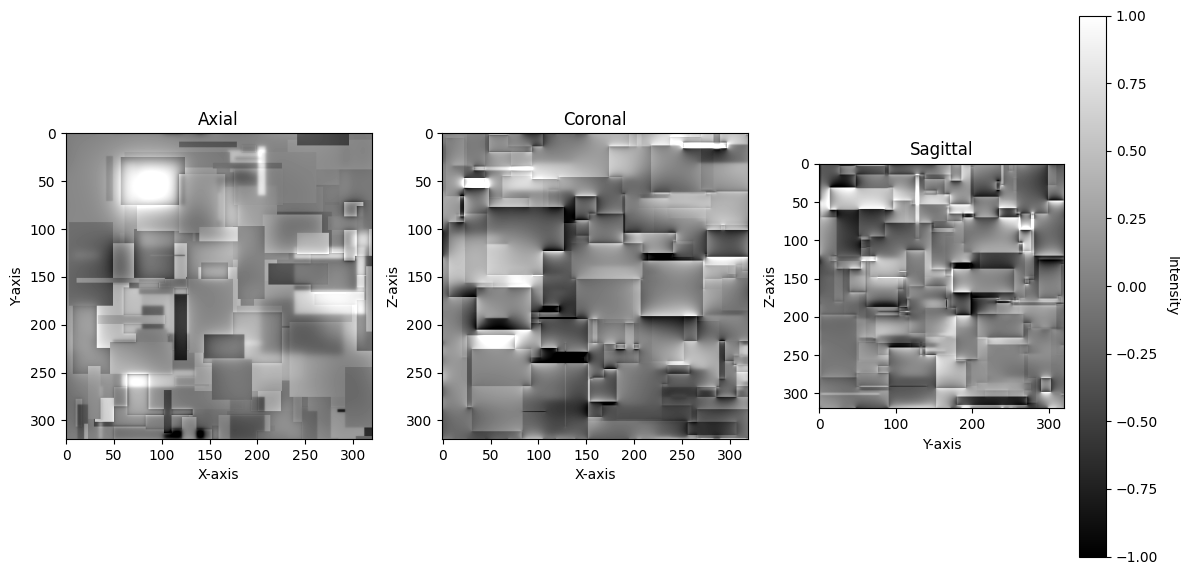

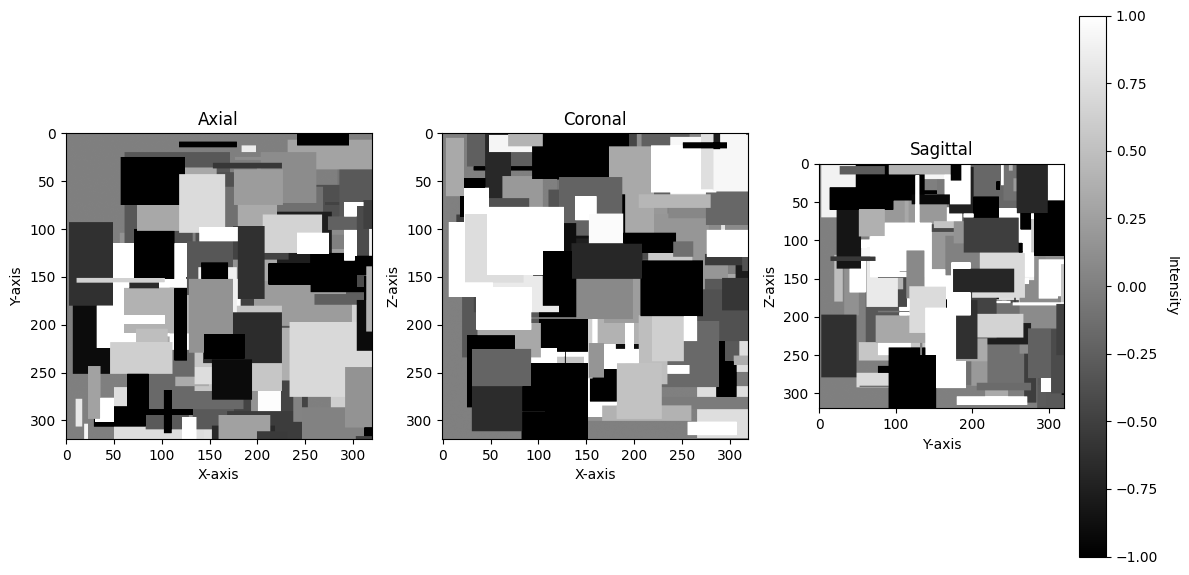

In [10]:
# Simulate tissue phase without padding
simulated_tissue_phase = simulate_mri_tissue_phase_no_padding(sim_gt_full)
view_slices_3d(simulated_tissue_phase, slice_nbr=100, vmin=-1, vmax=1)
view_slices_3d(sim_gt_full, slice_nbr=100, vmin=-1, vmax=1)

#### Training a model to invert the dipole convolution 

###### Prepare patches for training

In [11]:
total_patches = 500
training_dim = 64

# Split patches to train from our simulations in ground truth and forward
simulation_gt_patches = np.zeros((total_patches, training_dim, training_dim, training_dim))
simulation_fw_patches = np.zeros((total_patches, training_dim, training_dim, training_dim))


for patch_idx in range(total_patches):
  simulation_gt_patches[patch_idx, :, :, :], simulation_fw_patches[patch_idx, :, :, :] = create_batch(training_dim, patch_idx,sim_gt_full,simulated_tissue_phase)


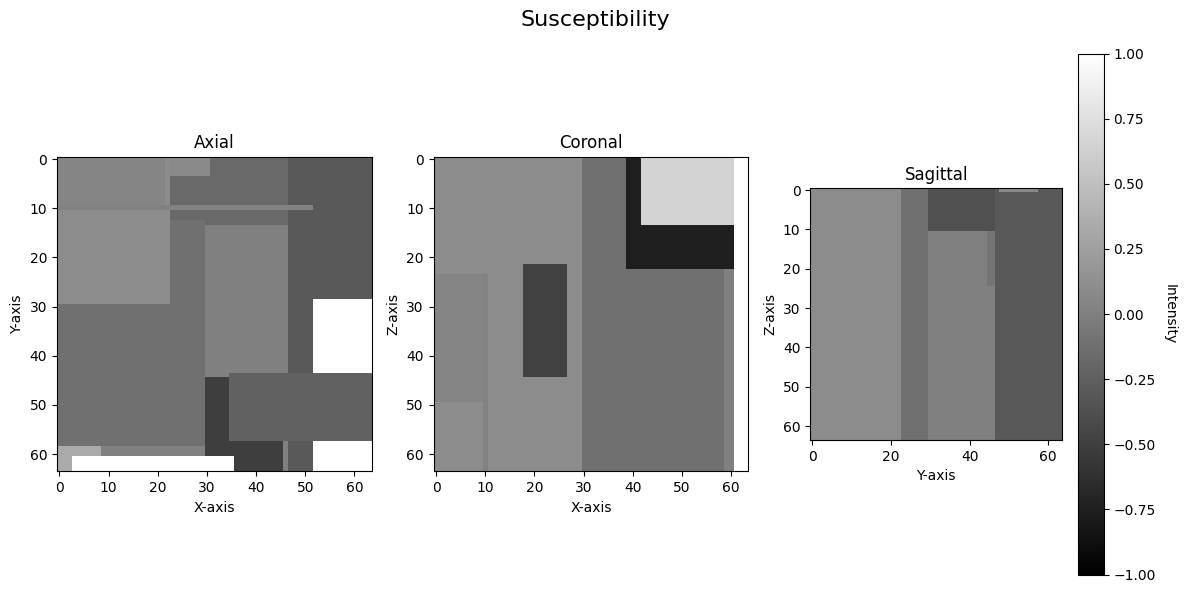

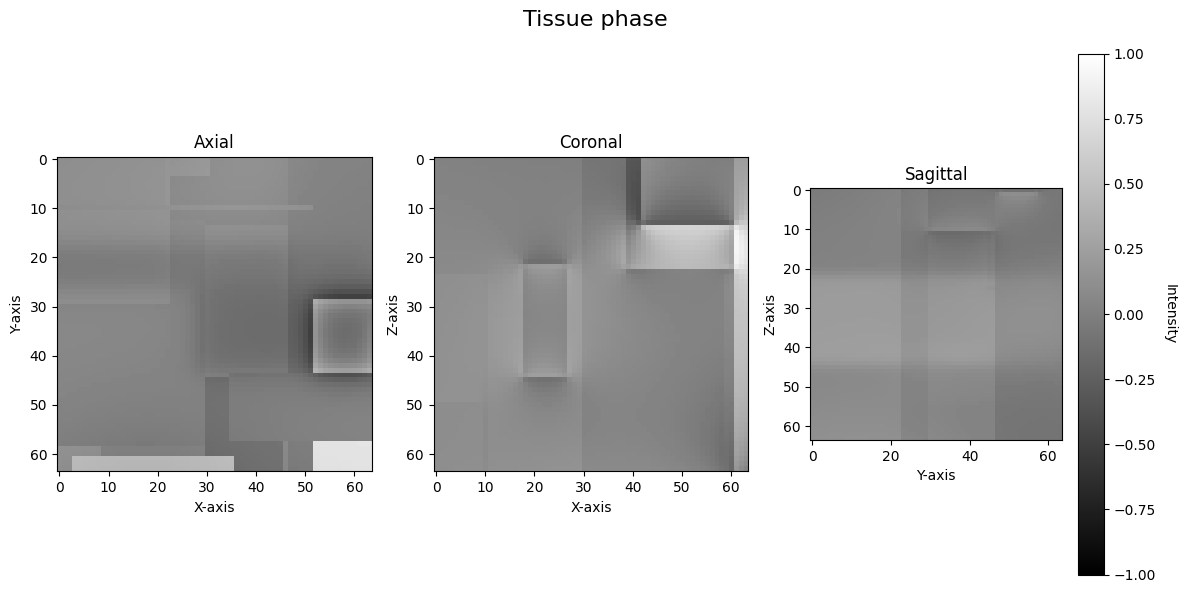

In [12]:
patch_idx = 40
view_slices_3d(simulation_gt_patches[patch_idx, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Susceptibility')
view_slices_3d(simulation_fw_patches[patch_idx, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Tissue phase')

##### Building architectures


In [13]:
# Print TensorFlow version
print(tf.__version__)

# Check GPU device availability
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('Running without GPU acceleration.')

2.12.0
Found GPU at: /device:GPU:0


###### Utils for architectures

In [14]:
# Utils function to construct the model

def downsample(filters, kernel_size, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv3D(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.LeakyReLU())

    return block


def upsample(filters, kernel_size, apply_dropout=False, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv3DTranspose(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        block.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        block.add(tf.keras.layers.Dropout(0.6))
    block.add(tf.keras.layers.ReLU())

    return block



class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch+1}:")
        print(f"  - Loss: {logs['loss']:.4f}")
        print(f"  - Mean Squared Error: {logs['mse']:.4f}")


In [15]:
# Testing downsample and upsample functions
inp = simulation_fw_patches[0,:,:,:]
print(f"Origianl shape in fw_pathces: {inp.shape}")
inp = tf.expand_dims(inp,0)
print(f"Expanding shape in fw_pathces first position: {inp.shape}")
inp = tf.expand_dims(inp,4)
print(f"Expanding shape in fw_pathces last position: {inp.shape}")

# Downsample
#(batch,x,y,z,channel)
down_sample = downsample(filters=8, kernel_size=4)
reduction = down_sample(inp)
print(f"Shape in fw_pathces after downsample: {reduction.shape}")

#Upsample
up_sample = upsample(filters=8, kernel_size=4)
expansion = up_sample(reduction)
print(f"Shape in fw_pathces after upsample: {expansion.shape}")

Origianl shape in fw_pathces: (64, 64, 64)
Expanding shape in fw_pathces first position: (1, 64, 64, 64)
Expanding shape in fw_pathces last position: (1, 64, 64, 64, 1)
Shape in fw_pathces after downsample: (1, 32, 32, 32, 8)
Shape in fw_pathces after upsample: (1, 64, 64, 64, 8)


###### ***Parameters***

In [16]:
EPOCHS = 200
PERIOD_TO_STORE = 25
OUTPUT_CHANNELS = 1

###### ***Model 1 - Architecture***

In [17]:
def model_1(filter_base=32, kernel_size=3):
    # Define the downsample blocks
    down_stack = [
        downsample(filter_base, kernel_size, apply_batch_norm=False),  # (base, 32, 32, 32, 64)
        downsample(filter_base * 2, kernel_size),                      # (base, 16, 16, 16, 128)
        downsample(filter_base * 3, kernel_size),                      # (base, 8, 8, 8, 256)
        downsample(filter_base * 4, kernel_size),                      # (base, 4, 4, 4, 512)
        downsample(filter_base * 5, kernel_size),                      # (base, 2, 2, 2, 1024)
    ]

    # Define the upsample blocks
    up_stack = [
        upsample(filter_base * 5, kernel_size, apply_dropout=True),     # (base, 4, 4, 4, 1024)
        upsample(filter_base * 4, kernel_size, apply_dropout=True),     # (base, 8, 8, 8, 512)
        upsample(filter_base * 3, kernel_size, apply_dropout=True),     # (base, 16, 16, 16, 256)
        upsample(filter_base * 2, kernel_size, apply_dropout=True),     # (base, 32, 32, 32, 128)
    ]

    # Define the final layer
    initializer = tf.random_normal_initializer(0., 0.02)
    final_layer = tf.keras.layers.Conv3DTranspose(OUTPUT_CHANNELS,
                                                  kernel_size,
                                                  strides=2,
                                                  padding='same',
                                                  kernel_initializer=initializer,
                                                  activation='tanh')  # (base, 256, 256, 3)

    concatenate = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, None, 1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # Reverse the skips for correct order in upsampling

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])

    x = final_layer(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
unet_model1 = model_1()

# Define the learning rate schedule
initial_learning_rate = 0.003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  # Adjust this value based on your dataset and training requirements
    decay_rate=0.96  # Adjust this value based on your dataset and training requirements
)

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model with the optimizer
unet_model1.compile(loss=losses.mean_squared_error, optimizer=optimizer)
unet_model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 sequential_2 (Sequential)      (None, None, None,   864         ['input_1[0][0]']                
                                None, 32)                                                         
                                                                                                  
 sequential_3 (Sequential)      (None, None, None,   55552       ['sequential_2[0][0]']           
                                None, 64)                                                     

###### ***Model 1 - Using the model to predict without training***

Shape of testing data: (1, 64, 64, 64, 1)
1/1 [==============================] - 1s 505ms/step
Shape of testing data: (1, 64, 64, 64, 1)


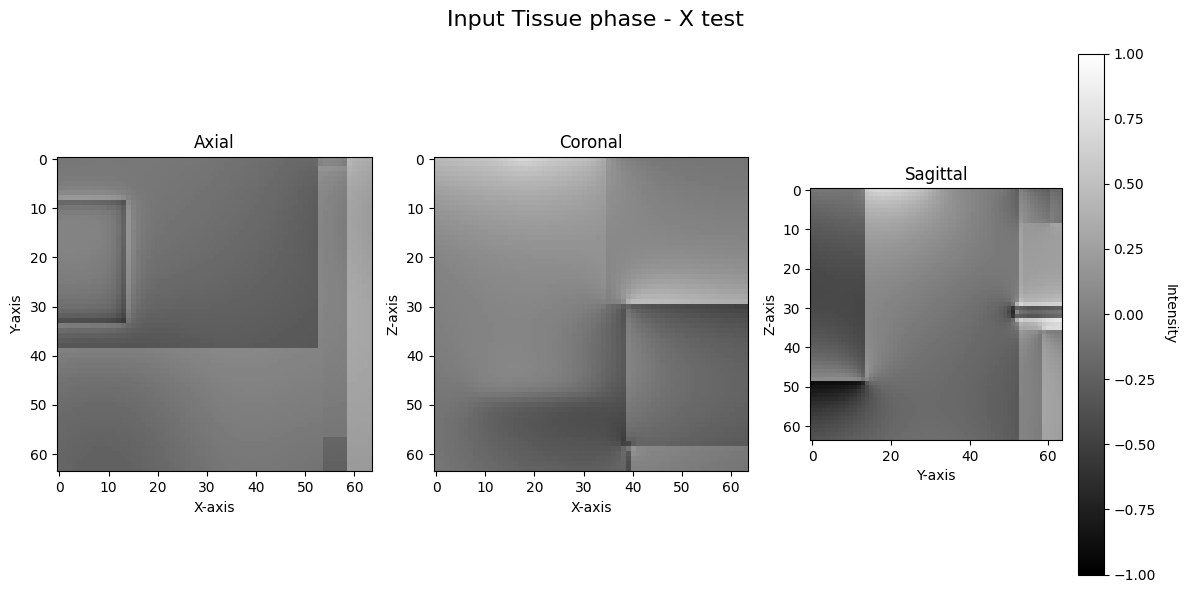

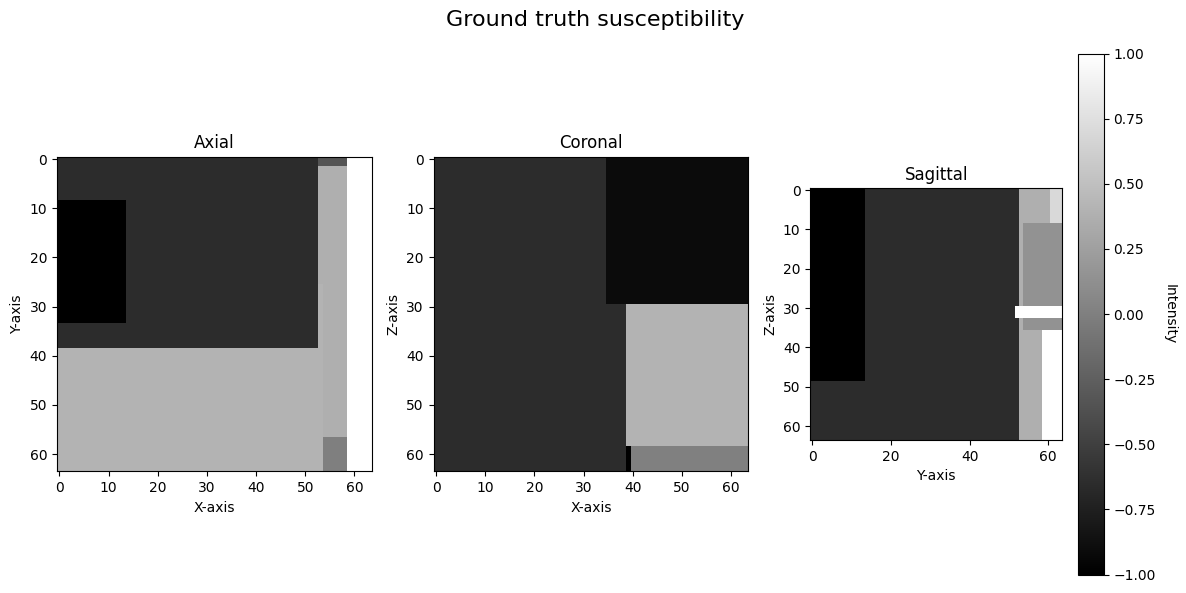

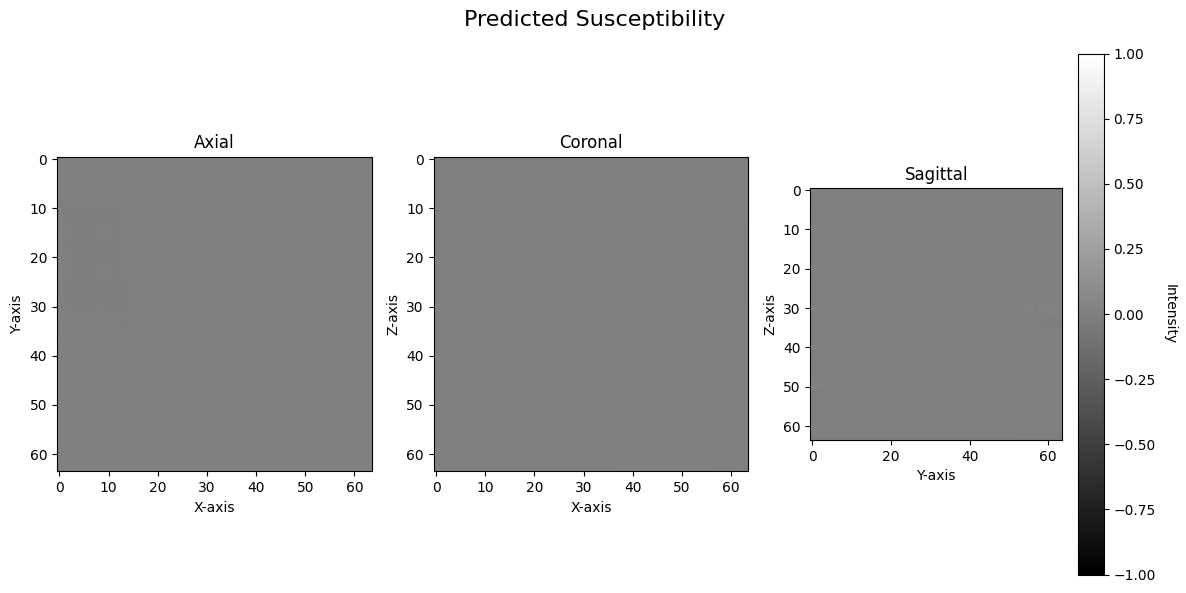

In [19]:
test_patch_nbr = 10
X_test = simulation_fw_patches[np.newaxis, test_patch_nbr,:,:,:, np.newaxis]
print(f"Shape of testing data: {X_test.shape}")

# Getting prediction from model without training
y_pred = unet_model1.predict(X_test)
print(f"Shape of testing data: {X_test.shape}")
view_slices_3d(X_test[0, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Input Tissue phase - X test')
view_slices_3d(simulation_gt_patches[test_patch_nbr, :, :, :], slice_nbr = 16, vmin = -1,vmax = 1, title='Ground truth susceptibility')
view_slices_3d(y_pred[0, :, :, :, 0], slice_nbr=16, vmin=-1, vmax=1, title='Predicted Susceptibility')


###### ***Model 1 - Trainning the model***

In [20]:
# Directories to store the checkpoints created
checkpoint_path_1 = "checkpoint_model_1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path_1)

# Callback to save checkpoints
cp_callback = ModelCheckpoint(
    checkpoint_path_1,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)


early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1
)

# Split data into training and validation sets
validation_split = 0.35
split_index = int(len(simulation_fw_patches) * (1 - validation_split))
train_images = tf.expand_dims(simulation_fw_patches[:split_index], 4)
train_labels = tf.expand_dims(simulation_gt_patches[:split_index], 4)
val_images = tf.expand_dims(simulation_fw_patches[split_index:], 4)
val_labels = tf.expand_dims(simulation_gt_patches[split_index:], 4)


# Train the model with validation data
loss_history_1 = []
with tqdm(total=EPOCHS, desc="Training") as pbar:
    for epoch in range(EPOCHS):
        pbar.set_postfix({'Epoch': epoch+1})
        history_1 = unet_model1.fit(
            train_images,
            train_labels,
            epochs=1,
            batch_size=30,
            shuffle=True,
            validation_data=(val_images, val_labels),
            callbacks=[cp_callback, early_stopping_callback]
        )
        
        loss_history_1.append(history_1.history["loss"][0])
        
        # Clear memory after each epoch
        del history_1
        tf.keras.backend.clear_session()
        
        pbar.update(1)

with open('loss_history_1.pickle', 'wb') as f:
    pickle.dump([loss_history_1, len(loss_history_1)], f)


Training:   0%|          | 0/200 [00:00<?, ?it/s, Epoch=1]

11/11 [==============================] - ETA: 0s - loss: 0.9916
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 17s 707ms/step - loss: 0.9916 - val_loss: 1.0080


Training:   0%|          | 1/200 [00:17<59:30, 17.94s/it, Epoch=2]

11/11 [==============================] - ETA: 0s - loss: 0.7923
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 417ms/step - loss: 0.7923 - val_loss: 1.0376


Training:   1%|          | 2/200 [00:23<35:19, 10.70s/it, Epoch=3]

11/11 [==============================] - ETA: 0s - loss: 0.6649
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.6649 - val_loss: 1.1930


Training:   2%|▏         | 3/200 [00:29<27:30,  8.38s/it, Epoch=4]

11/11 [==============================] - ETA: 0s - loss: 0.5565
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 454ms/step - loss: 0.5565 - val_loss: 1.1623


Training:   2%|▏         | 4/200 [00:34<23:38,  7.24s/it, Epoch=5]

11/11 [==============================] - ETA: 0s - loss: 0.4904
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 388ms/step - loss: 0.4904 - val_loss: 1.0674


Training:   2%|▎         | 5/200 [00:39<20:49,  6.41s/it, Epoch=6]

11/11 [==============================] - ETA: 0s - loss: 0.4496
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 385ms/step - loss: 0.4496 - val_loss: 1.0625


Training:   3%|▎         | 6/200 [00:45<19:49,  6.13s/it, Epoch=7]

11/11 [==============================] - ETA: 0s - loss: 0.4265
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 398ms/step - loss: 0.4265 - val_loss: 1.1448


Training:   4%|▎         | 7/200 [00:50<18:47,  5.84s/it, Epoch=8]

11/11 [==============================] - ETA: 0s - loss: 0.3856
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 385ms/step - loss: 0.3856 - val_loss: 0.9741


Training:   4%|▍         | 8/200 [00:56<18:25,  5.76s/it, Epoch=9]

11/11 [==============================] - ETA: 0s - loss: 0.3490
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 415ms/step - loss: 0.3490 - val_loss: 0.8300


Training:   4%|▍         | 9/200 [01:01<17:35,  5.53s/it, Epoch=10]

11/11 [==============================] - ETA: 0s - loss: 0.3348
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.3348 - val_loss: 0.6715


Training:   5%|▌         | 10/200 [01:06<17:34,  5.55s/it, Epoch=11]

11/11 [==============================] - ETA: 0s - loss: 0.3168
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 423ms/step - loss: 0.3168 - val_loss: 0.5633


Training:   6%|▌         | 11/200 [01:12<17:34,  5.58s/it, Epoch=12]

11/11 [==============================] - ETA: 0s - loss: 0.3025
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.3025 - val_loss: 0.5106


Training:   6%|▌         | 12/200 [01:17<16:53,  5.39s/it, Epoch=13]

11/11 [==============================] - ETA: 0s - loss: 0.2838
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 531ms/step - loss: 0.2838 - val_loss: 0.5172


Training:   6%|▋         | 13/200 [01:23<17:35,  5.64s/it, Epoch=14]

11/11 [==============================] - ETA: 0s - loss: 0.2719
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.2719 - val_loss: 0.4385


Training:   7%|▋         | 14/200 [01:28<17:07,  5.52s/it, Epoch=15]

11/11 [==============================] - ETA: 0s - loss: 0.2611
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 406ms/step - loss: 0.2611 - val_loss: 0.4288


Training:   8%|▊         | 15/200 [01:34<17:06,  5.55s/it, Epoch=16]

11/11 [==============================] - ETA: 0s - loss: 0.2538
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 406ms/step - loss: 0.2538 - val_loss: 0.4089


Training:   8%|▊         | 16/200 [01:39<16:45,  5.46s/it, Epoch=17]

11/11 [==============================] - ETA: 0s - loss: 0.2497
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 451ms/step - loss: 0.2497 - val_loss: 0.4000


Training:   8%|▊         | 17/200 [01:44<16:32,  5.43s/it, Epoch=18]

11/11 [==============================] - ETA: 0s - loss: 0.2501
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 421ms/step - loss: 0.2501 - val_loss: 0.3955


Training:   9%|▉         | 18/200 [01:50<16:09,  5.33s/it, Epoch=19]

11/11 [==============================] - ETA: 0s - loss: 0.2414
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 395ms/step - loss: 0.2414 - val_loss: 0.3660


Training:  10%|▉         | 19/200 [01:55<16:17,  5.40s/it, Epoch=20]

11/11 [==============================] - ETA: 0s - loss: 0.2360
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 415ms/step - loss: 0.2360 - val_loss: 0.3696


Training:  10%|█         | 20/200 [02:01<16:23,  5.46s/it, Epoch=21]

11/11 [==============================] - ETA: 0s - loss: 0.2374
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.2374 - val_loss: 0.3474


Training:  10%|█         | 21/200 [02:05<15:41,  5.26s/it, Epoch=22]

11/11 [==============================] - ETA: 0s - loss: 0.2286
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 403ms/step - loss: 0.2286 - val_loss: 0.3533


Training:  11%|█         | 22/200 [02:10<15:16,  5.15s/it, Epoch=23]

11/11 [==============================] - ETA: 0s - loss: 0.2262
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 408ms/step - loss: 0.2262 - val_loss: 0.3323


Training:  12%|█▏        | 23/200 [02:16<15:39,  5.31s/it, Epoch=24]

11/11 [==============================] - ETA: 0s - loss: 0.2204
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.2204 - val_loss: 0.3284


Training:  12%|█▏        | 24/200 [02:22<15:47,  5.38s/it, Epoch=25]

11/11 [==============================] - ETA: 0s - loss: 0.2161
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 424ms/step - loss: 0.2161 - val_loss: 0.3316


Training:  12%|█▎        | 25/200 [02:27<15:54,  5.45s/it, Epoch=26]

11/11 [==============================] - ETA: 0s - loss: 0.2175
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 400ms/step - loss: 0.2175 - val_loss: 0.3110


Training:  13%|█▎        | 26/200 [02:32<15:19,  5.28s/it, Epoch=27]

11/11 [==============================] - ETA: 0s - loss: 0.2151
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 448ms/step - loss: 0.2151 - val_loss: 0.3085


Training:  14%|█▎        | 27/200 [02:38<15:29,  5.38s/it, Epoch=28]

11/11 [==============================] - ETA: 0s - loss: 0.2153
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 392ms/step - loss: 0.2153 - val_loss: 0.3138


Training:  14%|█▍        | 28/200 [02:43<14:55,  5.21s/it, Epoch=29]

11/11 [==============================] - ETA: 0s - loss: 0.2132
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 392ms/step - loss: 0.2132 - val_loss: 0.2999


Training:  14%|█▍        | 29/200 [02:48<15:10,  5.32s/it, Epoch=30]

11/11 [==============================] - ETA: 0s - loss: 0.2143
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 392ms/step - loss: 0.2143 - val_loss: 0.2972


Training:  15%|█▌        | 30/200 [02:53<15:00,  5.30s/it, Epoch=31]

11/11 [==============================] - ETA: 0s - loss: 0.2092
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 399ms/step - loss: 0.2092 - val_loss: 0.3087


Training:  16%|█▌        | 31/200 [02:59<15:11,  5.39s/it, Epoch=32]

11/11 [==============================] - ETA: 0s - loss: 0.2097
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 415ms/step - loss: 0.2097 - val_loss: 0.2870


Training:  16%|█▌        | 32/200 [03:05<15:18,  5.47s/it, Epoch=33]

11/11 [==============================] - ETA: 0s - loss: 0.2102
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.2102 - val_loss: 0.3004


Training:  16%|█▋        | 33/200 [03:09<14:39,  5.27s/it, Epoch=34]

11/11 [==============================] - ETA: 0s - loss: 0.2104
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 433ms/step - loss: 0.2104 - val_loss: 0.2932


Training:  17%|█▋        | 34/200 [03:15<14:32,  5.26s/it, Epoch=35]

11/11 [==============================] - ETA: 0s - loss: 0.2048
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.2048 - val_loss: 0.2828


Training:  18%|█▊        | 35/200 [03:19<14:05,  5.13s/it, Epoch=36]

11/11 [==============================] - ETA: 0s - loss: 0.2018
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 398ms/step - loss: 0.2018 - val_loss: 0.2878


Training:  18%|█▊        | 36/200 [03:25<14:23,  5.27s/it, Epoch=37]

11/11 [==============================] - ETA: 0s - loss: 0.2010
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 397ms/step - loss: 0.2010 - val_loss: 0.2839


Training:  18%|█▊        | 37/200 [03:31<14:49,  5.46s/it, Epoch=38]

11/11 [==============================] - ETA: 0s - loss: 0.2025
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.2025 - val_loss: 0.2874


Training:  19%|█▉        | 38/200 [03:37<14:51,  5.50s/it, Epoch=39]

11/11 [==============================] - ETA: 0s - loss: 0.1992
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 395ms/step - loss: 0.1992 - val_loss: 0.2755


Training:  20%|█▉        | 39/200 [03:42<15:03,  5.61s/it, Epoch=40]

11/11 [==============================] - ETA: 0s - loss: 0.2087
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.2087 - val_loss: 0.2836


Training:  20%|██        | 40/200 [03:47<14:19,  5.37s/it, Epoch=41]

11/11 [==============================] - ETA: 0s - loss: 0.2005
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 479ms/step - loss: 0.2005 - val_loss: 0.2748


Training:  20%|██        | 41/200 [03:53<14:29,  5.47s/it, Epoch=42]

11/11 [==============================] - ETA: 0s - loss: 0.2014
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.2014 - val_loss: 0.2782


Training:  21%|██        | 42/200 [03:58<13:54,  5.28s/it, Epoch=43]

11/11 [==============================] - ETA: 0s - loss: 0.1979
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 429ms/step - loss: 0.1979 - val_loss: 0.2754


Training:  22%|██▏       | 43/200 [04:03<13:44,  5.25s/it, Epoch=44]

11/11 [==============================] - ETA: 0s - loss: 0.1986
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 405ms/step - loss: 0.1986 - val_loss: 0.2742


Training:  22%|██▏       | 44/200 [04:09<13:54,  5.35s/it, Epoch=45]

11/11 [==============================] - ETA: 0s - loss: 0.1931
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 400ms/step - loss: 0.1931 - val_loss: 0.2714


Training:  22%|██▎       | 45/200 [04:13<13:28,  5.22s/it, Epoch=46]

11/11 [==============================] - ETA: 0s - loss: 0.1925
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 452ms/step - loss: 0.1925 - val_loss: 0.2710


Training:  23%|██▎       | 46/200 [04:19<13:54,  5.42s/it, Epoch=47]

11/11 [==============================] - ETA: 0s - loss: 0.1925
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 395ms/step - loss: 0.1925 - val_loss: 0.2704


Training:  24%|██▎       | 47/200 [04:25<13:57,  5.47s/it, Epoch=48]

11/11 [==============================] - ETA: 0s - loss: 0.1913
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 406ms/step - loss: 0.1913 - val_loss: 0.2714


Training:  24%|██▍       | 48/200 [04:30<13:44,  5.43s/it, Epoch=49]

11/11 [==============================] - ETA: 0s - loss: 0.1925
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 452ms/step - loss: 0.1925 - val_loss: 0.2702


Training:  24%|██▍       | 49/200 [04:36<13:46,  5.47s/it, Epoch=50]

11/11 [==============================] - ETA: 0s - loss: 0.1965
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 413ms/step - loss: 0.1965 - val_loss: 0.2745


Training:  25%|██▌       | 50/200 [04:41<13:19,  5.33s/it, Epoch=51]

11/11 [==============================] - ETA: 0s - loss: 0.1996
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 392ms/step - loss: 0.1996 - val_loss: 0.2737


Training:  26%|██▌       | 51/200 [04:46<12:51,  5.18s/it, Epoch=52]

11/11 [==============================] - ETA: 0s - loss: 0.1956
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 461ms/step - loss: 0.1956 - val_loss: 0.2720


Training:  26%|██▌       | 52/200 [04:51<13:05,  5.31s/it, Epoch=53]

11/11 [==============================] - ETA: 0s - loss: 0.1942
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 407ms/step - loss: 0.1942 - val_loss: 0.2814


Training:  26%|██▋       | 53/200 [04:57<13:21,  5.45s/it, Epoch=54]

11/11 [==============================] - ETA: 0s - loss: 0.1938
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 400ms/step - loss: 0.1938 - val_loss: 0.2690


Training:  27%|██▋       | 54/200 [05:03<13:23,  5.50s/it, Epoch=55]

11/11 [==============================] - ETA: 0s - loss: 0.1942
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 399ms/step - loss: 0.1942 - val_loss: 0.2681


Training:  28%|██▊       | 55/200 [05:08<13:08,  5.44s/it, Epoch=56]

11/11 [==============================] - ETA: 0s - loss: 0.2002
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 401ms/step - loss: 0.2002 - val_loss: 0.2764


Training:  28%|██▊       | 56/200 [05:14<13:09,  5.48s/it, Epoch=57]

11/11 [==============================] - ETA: 0s - loss: 0.1932
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 415ms/step - loss: 0.1932 - val_loss: 0.2733


Training:  28%|██▊       | 57/200 [05:19<13:19,  5.59s/it, Epoch=58]

11/11 [==============================] - ETA: 0s - loss: 0.1942
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 401ms/step - loss: 0.1942 - val_loss: 0.2672


Training:  29%|██▉       | 58/200 [05:24<12:45,  5.39s/it, Epoch=59]

11/11 [==============================] - ETA: 0s - loss: 0.1906
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 432ms/step - loss: 0.1906 - val_loss: 0.2646


Training:  30%|██▉       | 59/200 [05:30<12:33,  5.34s/it, Epoch=60]

11/11 [==============================] - ETA: 0s - loss: 0.1905
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 393ms/step - loss: 0.1905 - val_loss: 0.2690


Training:  30%|███       | 60/200 [05:35<12:38,  5.42s/it, Epoch=61]

11/11 [==============================] - ETA: 0s - loss: 0.1905
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 422ms/step - loss: 0.1905 - val_loss: 0.2727


Training:  30%|███       | 61/200 [05:41<12:41,  5.48s/it, Epoch=62]

11/11 [==============================] - ETA: 0s - loss: 0.1904
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 396ms/step - loss: 0.1904 - val_loss: 0.2714


Training:  31%|███       | 62/200 [05:46<12:40,  5.51s/it, Epoch=63]

11/11 [==============================] - ETA: 0s - loss: 0.1958
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 403ms/step - loss: 0.1958 - val_loss: 0.2669


Training:  32%|███▏      | 63/200 [05:52<12:39,  5.54s/it, Epoch=64]

11/11 [==============================] - ETA: 0s - loss: 0.1907
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 393ms/step - loss: 0.1907 - val_loss: 0.2704


Training:  32%|███▏      | 64/200 [05:57<12:15,  5.41s/it, Epoch=65]

11/11 [==============================] - ETA: 0s - loss: 0.1906
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 388ms/step - loss: 0.1906 - val_loss: 0.2670


Training:  32%|███▎      | 65/200 [06:02<11:43,  5.21s/it, Epoch=66]

11/11 [==============================] - ETA: 0s - loss: 0.1886
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 432ms/step - loss: 0.1886 - val_loss: 0.2637


Training:  33%|███▎      | 66/200 [06:07<11:54,  5.33s/it, Epoch=67]

11/11 [==============================] - ETA: 0s - loss: 0.1870
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.1870 - val_loss: 0.2620


Training:  34%|███▎      | 67/200 [06:13<12:00,  5.41s/it, Epoch=68]

11/11 [==============================] - ETA: 0s - loss: 0.1871
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 428ms/step - loss: 0.1871 - val_loss: 0.2647


Training:  34%|███▍      | 68/200 [06:18<11:43,  5.33s/it, Epoch=69]

11/11 [==============================] - ETA: 0s - loss: 0.1864
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.1864 - val_loss: 0.2650


Training:  34%|███▍      | 69/200 [06:24<11:49,  5.42s/it, Epoch=70]

11/11 [==============================] - ETA: 0s - loss: 0.1941
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 423ms/step - loss: 0.1941 - val_loss: 0.2630


Training:  35%|███▌      | 70/200 [06:29<11:50,  5.47s/it, Epoch=71]

11/11 [==============================] - ETA: 0s - loss: 0.1904
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.1904 - val_loss: 0.2690


Training:  36%|███▌      | 71/200 [06:35<11:50,  5.51s/it, Epoch=72]

11/11 [==============================] - ETA: 0s - loss: 0.1855
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 460ms/step - loss: 0.1855 - val_loss: 0.2682


Training:  36%|███▌      | 72/200 [06:41<11:48,  5.53s/it, Epoch=73]

11/11 [==============================] - ETA: 0s - loss: 0.1875
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 396ms/step - loss: 0.1875 - val_loss: 0.2698


Training:  36%|███▋      | 73/200 [06:46<11:29,  5.43s/it, Epoch=74]

11/11 [==============================] - ETA: 0s - loss: 0.1894
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 427ms/step - loss: 0.1894 - val_loss: 0.2667


Training:  37%|███▋      | 74/200 [06:51<11:13,  5.35s/it, Epoch=75]

11/11 [==============================] - ETA: 0s - loss: 0.1871
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 408ms/step - loss: 0.1871 - val_loss: 0.2666


Training:  38%|███▊      | 75/200 [06:57<11:37,  5.58s/it, Epoch=76]

11/11 [==============================] - ETA: 0s - loss: 0.1940
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 403ms/step - loss: 0.1940 - val_loss: 0.2662


Training:  38%|███▊      | 76/200 [07:03<11:43,  5.67s/it, Epoch=77]

11/11 [==============================] - ETA: 0s - loss: 0.1900
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 430ms/step - loss: 0.1900 - val_loss: 0.2719


Training:  38%|███▊      | 77/200 [07:09<11:44,  5.73s/it, Epoch=78]

11/11 [==============================] - ETA: 0s - loss: 0.1932
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 397ms/step - loss: 0.1932 - val_loss: 0.2666


Training:  39%|███▉      | 78/200 [07:15<11:40,  5.74s/it, Epoch=79]

11/11 [==============================] - ETA: 0s - loss: 0.1957
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 470ms/step - loss: 0.1957 - val_loss: 0.2648


Training:  40%|███▉      | 79/200 [07:25<14:40,  7.28s/it, Epoch=80]

11/11 [==============================] - ETA: 0s - loss: 0.1951
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 433ms/step - loss: 0.1951 - val_loss: 0.2739


Training:  40%|████      | 80/200 [07:31<13:27,  6.73s/it, Epoch=81]

11/11 [==============================] - ETA: 0s - loss: 0.1875
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 397ms/step - loss: 0.1875 - val_loss: 0.2694


Training:  40%|████      | 81/200 [07:37<12:43,  6.42s/it, Epoch=82]

11/11 [==============================] - ETA: 0s - loss: 0.1872
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.1872 - val_loss: 0.2604


Training:  41%|████      | 82/200 [07:41<11:42,  5.96s/it, Epoch=83]

11/11 [==============================] - ETA: 0s - loss: 0.1837
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 401ms/step - loss: 0.1837 - val_loss: 0.2590


Training:  42%|████▏     | 83/200 [07:47<11:35,  5.94s/it, Epoch=84]

11/11 [==============================] - ETA: 0s - loss: 0.1821
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.1821 - val_loss: 0.2602


Training:  42%|████▏     | 84/200 [07:53<11:17,  5.84s/it, Epoch=85]

11/11 [==============================] - ETA: 0s - loss: 0.1841
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 417ms/step - loss: 0.1841 - val_loss: 0.2629


Training:  42%|████▎     | 85/200 [07:59<11:11,  5.84s/it, Epoch=86]

11/11 [==============================] - ETA: 0s - loss: 0.1812
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 397ms/step - loss: 0.1812 - val_loss: 0.2598


Training:  43%|████▎     | 86/200 [08:04<10:30,  5.54s/it, Epoch=87]

11/11 [==============================] - ETA: 0s - loss: 0.1797
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 424ms/step - loss: 0.1797 - val_loss: 0.2608


Training:  44%|████▎     | 87/200 [08:09<10:12,  5.42s/it, Epoch=88]

11/11 [==============================] - ETA: 0s - loss: 0.1818
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 406ms/step - loss: 0.1818 - val_loss: 0.2601


Training:  44%|████▍     | 88/200 [08:14<09:52,  5.29s/it, Epoch=89]

11/11 [==============================] - ETA: 0s - loss: 0.1854
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 412ms/step - loss: 0.1854 - val_loss: 0.2644


Training:  44%|████▍     | 89/200 [08:19<09:58,  5.39s/it, Epoch=90]

11/11 [==============================] - ETA: 0s - loss: 0.1852
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.1852 - val_loss: 0.2693


Training:  45%|████▌     | 90/200 [08:24<09:41,  5.28s/it, Epoch=91]

11/11 [==============================] - ETA: 0s - loss: 0.1865
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 386ms/step - loss: 0.1865 - val_loss: 0.2657


Training:  46%|████▌     | 91/200 [08:30<09:46,  5.38s/it, Epoch=92]

11/11 [==============================] - ETA: 0s - loss: 0.1833
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 406ms/step - loss: 0.1833 - val_loss: 0.2646


Training:  46%|████▌     | 92/200 [08:36<09:57,  5.54s/it, Epoch=93]

11/11 [==============================] - ETA: 0s - loss: 0.1821
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 385ms/step - loss: 0.1821 - val_loss: 0.2604


Training:  46%|████▋     | 93/200 [08:41<09:25,  5.29s/it, Epoch=94]

11/11 [==============================] - ETA: 0s - loss: 0.1833
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 406ms/step - loss: 0.1833 - val_loss: 0.2665


Training:  47%|████▋     | 94/200 [08:46<09:30,  5.38s/it, Epoch=95]

11/11 [==============================] - ETA: 0s - loss: 0.1862
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.1862 - val_loss: 0.2623


Training:  48%|████▊     | 95/200 [08:52<09:31,  5.44s/it, Epoch=96]

11/11 [==============================] - ETA: 0s - loss: 0.1819
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 416ms/step - loss: 0.1819 - val_loss: 0.2687


Training:  48%|████▊     | 96/200 [08:57<09:12,  5.32s/it, Epoch=97]

11/11 [==============================] - ETA: 0s - loss: 0.1831
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 400ms/step - loss: 0.1831 - val_loss: 0.2619


Training:  48%|████▊     | 97/200 [09:02<09:16,  5.41s/it, Epoch=98]

11/11 [==============================] - ETA: 0s - loss: 0.1821
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 422ms/step - loss: 0.1821 - val_loss: 0.2598


Training:  49%|████▉     | 98/200 [09:08<09:16,  5.46s/it, Epoch=99]

11/11 [==============================] - ETA: 0s - loss: 0.1797
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 393ms/step - loss: 0.1797 - val_loss: 0.2591


Training:  50%|████▉     | 99/200 [09:14<09:22,  5.57s/it, Epoch=100]

11/11 [==============================] - ETA: 0s - loss: 0.1818
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 393ms/step - loss: 0.1818 - val_loss: 0.2599


Training:  50%|█████     | 100/200 [09:19<08:53,  5.34s/it, Epoch=101]

11/11 [==============================] - ETA: 0s - loss: 0.1817
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 404ms/step - loss: 0.1817 - val_loss: 0.2575


Training:  50%|█████     | 101/200 [09:25<09:04,  5.50s/it, Epoch=102]

11/11 [==============================] - ETA: 0s - loss: 0.1835
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 393ms/step - loss: 0.1835 - val_loss: 0.2606


Training:  51%|█████     | 102/200 [09:30<09:01,  5.53s/it, Epoch=103]

11/11 [==============================] - ETA: 0s - loss: 0.1798
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 428ms/step - loss: 0.1798 - val_loss: 0.2616


Training:  52%|█████▏    | 103/200 [09:36<08:58,  5.55s/it, Epoch=104]

11/11 [==============================] - ETA: 0s - loss: 0.1795
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 398ms/step - loss: 0.1795 - val_loss: 0.2598


Training:  52%|█████▏    | 104/200 [09:41<08:33,  5.35s/it, Epoch=105]

11/11 [==============================] - ETA: 0s - loss: 0.1783
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 427ms/step - loss: 0.1783 - val_loss: 0.2623


Training:  52%|█████▎    | 105/200 [09:46<08:35,  5.43s/it, Epoch=106]

11/11 [==============================] - ETA: 0s - loss: 0.1804
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 397ms/step - loss: 0.1804 - val_loss: 0.2622


Training:  53%|█████▎    | 106/200 [09:51<08:14,  5.26s/it, Epoch=107]

11/11 [==============================] - ETA: 0s - loss: 0.1840
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 395ms/step - loss: 0.1840 - val_loss: 0.2616


Training:  54%|█████▎    | 107/200 [09:57<08:19,  5.37s/it, Epoch=108]

11/11 [==============================] - ETA: 0s - loss: 0.1831
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.1831 - val_loss: 0.2620


Training:  54%|█████▍    | 108/200 [10:02<08:08,  5.31s/it, Epoch=109]

11/11 [==============================] - ETA: 0s - loss: 0.1814
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.1814 - val_loss: 0.2605


Training:  55%|█████▍    | 109/200 [10:07<08:10,  5.39s/it, Epoch=110]

11/11 [==============================] - ETA: 0s - loss: 0.1800
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 413ms/step - loss: 0.1800 - val_loss: 0.2634


Training:  55%|█████▌    | 110/200 [10:13<08:18,  5.54s/it, Epoch=111]

11/11 [==============================] - ETA: 0s - loss: 0.1813
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 400ms/step - loss: 0.1813 - val_loss: 0.2660


Training:  56%|█████▌    | 111/200 [10:19<08:14,  5.56s/it, Epoch=112]

11/11 [==============================] - ETA: 0s - loss: 0.1801
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 430ms/step - loss: 0.1801 - val_loss: 0.2643


Training:  56%|█████▌    | 112/200 [10:24<07:59,  5.44s/it, Epoch=113]

11/11 [==============================] - ETA: 0s - loss: 0.1817
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 396ms/step - loss: 0.1817 - val_loss: 0.2586


Training:  56%|█████▋    | 113/200 [10:29<07:37,  5.26s/it, Epoch=114]

11/11 [==============================] - ETA: 0s - loss: 0.1837
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 436ms/step - loss: 0.1837 - val_loss: 0.2647


Training:  57%|█████▋    | 114/200 [10:35<07:41,  5.36s/it, Epoch=115]

11/11 [==============================] - ETA: 0s - loss: 0.1803
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.1803 - val_loss: 0.2643


Training:  57%|█████▊    | 115/200 [10:40<07:41,  5.43s/it, Epoch=116]

11/11 [==============================] - ETA: 0s - loss: 0.1794
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 452ms/step - loss: 0.1794 - val_loss: 0.2602


Training:  58%|█████▊    | 116/200 [10:46<07:37,  5.45s/it, Epoch=117]

11/11 [==============================] - ETA: 0s - loss: 0.1779
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 402ms/step - loss: 0.1779 - val_loss: 0.2615


Training:  58%|█████▊    | 117/200 [10:52<07:42,  5.58s/it, Epoch=118]

11/11 [==============================] - ETA: 0s - loss: 0.1778
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 389ms/step - loss: 0.1778 - val_loss: 0.2618


Training:  59%|█████▉    | 118/200 [10:56<07:17,  5.34s/it, Epoch=119]

11/11 [==============================] - ETA: 0s - loss: 0.1776
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 418ms/step - loss: 0.1776 - val_loss: 0.2582


Training:  60%|█████▉    | 119/200 [11:02<07:12,  5.34s/it, Epoch=120]

11/11 [==============================] - ETA: 0s - loss: 0.1796
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 399ms/step - loss: 0.1796 - val_loss: 0.2587


Training:  60%|██████    | 120/200 [11:07<06:56,  5.21s/it, Epoch=121]

11/11 [==============================] - ETA: 0s - loss: 0.1800
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 437ms/step - loss: 0.1800 - val_loss: 0.2627


Training:  60%|██████    | 121/200 [11:12<06:53,  5.24s/it, Epoch=122]

11/11 [==============================] - ETA: 0s - loss: 0.1821
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.1821 - val_loss: 0.2614


Training:  61%|██████    | 122/200 [11:17<06:57,  5.35s/it, Epoch=123]

11/11 [==============================] - ETA: 0s - loss: 0.1802
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 419ms/step - loss: 0.1802 - val_loss: 0.2624


Training:  62%|██████▏   | 123/200 [11:23<06:45,  5.27s/it, Epoch=124]

11/11 [==============================] - ETA: 0s - loss: 0.1783
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.1783 - val_loss: 0.2623


Training:  62%|██████▏   | 124/200 [11:28<06:39,  5.25s/it, Epoch=125]

11/11 [==============================] - ETA: 0s - loss: 0.1812
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 403ms/step - loss: 0.1812 - val_loss: 0.2603


Training:  62%|██████▎   | 125/200 [11:33<06:41,  5.35s/it, Epoch=126]

11/11 [==============================] - ETA: 0s - loss: 0.1802
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 428ms/step - loss: 0.1802 - val_loss: 0.2622


Training:  63%|██████▎   | 126/200 [11:39<06:44,  5.47s/it, Epoch=127]

11/11 [==============================] - ETA: 0s - loss: 0.1799
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.1799 - val_loss: 0.2592


Training:  64%|██████▎   | 127/200 [11:45<06:41,  5.51s/it, Epoch=128]

11/11 [==============================] - ETA: 0s - loss: 0.1778
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 411ms/step - loss: 0.1778 - val_loss: 0.2604


Training:  64%|██████▍   | 128/200 [11:50<06:38,  5.54s/it, Epoch=129]

11/11 [==============================] - ETA: 0s - loss: 0.1773
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.1773 - val_loss: 0.2589


Training:  64%|██████▍   | 129/200 [11:55<06:17,  5.32s/it, Epoch=130]

11/11 [==============================] - ETA: 0s - loss: 0.1814
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 428ms/step - loss: 0.1814 - val_loss: 0.2639


Training:  65%|██████▌   | 130/200 [12:01<06:19,  5.41s/it, Epoch=131]

11/11 [==============================] - ETA: 0s - loss: 0.1776
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 403ms/step - loss: 0.1776 - val_loss: 0.2615


Training:  66%|██████▌   | 131/200 [12:06<06:04,  5.28s/it, Epoch=132]

11/11 [==============================] - ETA: 0s - loss: 0.1762
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 393ms/step - loss: 0.1762 - val_loss: 0.2606


Training:  66%|██████▌   | 132/200 [12:11<05:50,  5.15s/it, Epoch=133]

11/11 [==============================] - ETA: 0s - loss: 0.1765
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 403ms/step - loss: 0.1765 - val_loss: 0.2604


Training:  66%|██████▋   | 133/200 [12:16<05:48,  5.20s/it, Epoch=134]

11/11 [==============================] - ETA: 0s - loss: 0.1758
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.1758 - val_loss: 0.2593


Training:  67%|██████▋   | 134/200 [12:21<05:51,  5.32s/it, Epoch=135]

11/11 [==============================] - ETA: 0s - loss: 0.1769
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 418ms/step - loss: 0.1769 - val_loss: 0.2582


Training:  68%|██████▊   | 135/200 [12:27<05:51,  5.41s/it, Epoch=136]

11/11 [==============================] - ETA: 0s - loss: 0.1755
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 378ms/step - loss: 0.1755 - val_loss: 0.2590


Training:  68%|██████▊   | 136/200 [12:32<05:32,  5.19s/it, Epoch=137]

11/11 [==============================] - ETA: 0s - loss: 0.1770
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 412ms/step - loss: 0.1770 - val_loss: 0.2589


Training:  68%|██████▊   | 137/200 [12:37<05:24,  5.14s/it, Epoch=138]

11/11 [==============================] - ETA: 0s - loss: 0.1762
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.1762 - val_loss: 0.2576


Training:  69%|██████▉   | 138/200 [12:43<05:33,  5.38s/it, Epoch=139]

11/11 [==============================] - ETA: 0s - loss: 0.1748
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 402ms/step - loss: 0.1748 - val_loss: 0.2595


Training:  70%|██████▉   | 139/200 [12:48<05:32,  5.45s/it, Epoch=140]

11/11 [==============================] - ETA: 0s - loss: 0.1754
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 401ms/step - loss: 0.1754 - val_loss: 0.2595


Training:  70%|███████   | 140/200 [12:54<05:35,  5.58s/it, Epoch=141]

11/11 [==============================] - ETA: 0s - loss: 0.1749
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.1749 - val_loss: 0.2568


Training:  70%|███████   | 141/200 [13:00<05:29,  5.59s/it, Epoch=142]

11/11 [==============================] - ETA: 0s - loss: 0.1773
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 428ms/step - loss: 0.1773 - val_loss: 0.2572


Training:  71%|███████   | 142/200 [13:05<05:24,  5.60s/it, Epoch=143]

11/11 [==============================] - ETA: 0s - loss: 0.1761
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 400ms/step - loss: 0.1761 - val_loss: 0.2571


Training:  72%|███████▏  | 143/200 [13:11<05:19,  5.60s/it, Epoch=144]

11/11 [==============================] - ETA: 0s - loss: 0.1754
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 427ms/step - loss: 0.1754 - val_loss: 0.2611


Training:  72%|███████▏  | 144/200 [13:17<05:13,  5.60s/it, Epoch=145]

11/11 [==============================] - ETA: 0s - loss: 0.1756
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 407ms/step - loss: 0.1756 - val_loss: 0.2641


Training:  72%|███████▎  | 145/200 [13:22<04:57,  5.41s/it, Epoch=146]

11/11 [==============================] - ETA: 0s - loss: 0.1773
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 427ms/step - loss: 0.1773 - val_loss: 0.2598


Training:  73%|███████▎  | 146/200 [13:27<04:55,  5.47s/it, Epoch=147]

11/11 [==============================] - ETA: 0s - loss: 0.1779
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 397ms/step - loss: 0.1779 - val_loss: 0.2624


Training:  74%|███████▎  | 147/200 [13:32<04:42,  5.32s/it, Epoch=148]

11/11 [==============================] - ETA: 0s - loss: 0.1841
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 396ms/step - loss: 0.1841 - val_loss: 0.2644


Training:  74%|███████▍  | 148/200 [13:37<04:30,  5.20s/it, Epoch=149]

11/11 [==============================] - ETA: 0s - loss: 0.1827
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 435ms/step - loss: 0.1827 - val_loss: 0.2635


Training:  74%|███████▍  | 149/200 [13:43<04:31,  5.33s/it, Epoch=150]

11/11 [==============================] - ETA: 0s - loss: 0.1801
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 402ms/step - loss: 0.1801 - val_loss: 0.2624


Training:  75%|███████▌  | 150/200 [13:48<04:30,  5.41s/it, Epoch=151]

11/11 [==============================] - ETA: 0s - loss: 0.1806
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 424ms/step - loss: 0.1806 - val_loss: 0.2637


Training:  76%|███████▌  | 151/200 [13:54<04:28,  5.47s/it, Epoch=152]

11/11 [==============================] - ETA: 0s - loss: 0.1760
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 386ms/step - loss: 0.1760 - val_loss: 0.2609


Training:  76%|███████▌  | 152/200 [14:00<04:24,  5.51s/it, Epoch=153]

11/11 [==============================] - ETA: 0s - loss: 0.1755
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 432ms/step - loss: 0.1755 - val_loss: 0.2554


Training:  76%|███████▋  | 153/200 [14:05<04:20,  5.54s/it, Epoch=154]

11/11 [==============================] - ETA: 0s - loss: 0.1741
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 400ms/step - loss: 0.1741 - val_loss: 0.2573


Training:  77%|███████▋  | 154/200 [14:10<04:06,  5.35s/it, Epoch=155]

11/11 [==============================] - ETA: 0s - loss: 0.1749
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 406ms/step - loss: 0.1749 - val_loss: 0.2567


Training:  78%|███████▊  | 155/200 [14:15<03:55,  5.24s/it, Epoch=156]

11/11 [==============================] - ETA: 0s - loss: 0.1758
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 393ms/step - loss: 0.1758 - val_loss: 0.2598


Training:  78%|███████▊  | 156/200 [14:21<03:59,  5.44s/it, Epoch=157]

11/11 [==============================] - ETA: 0s - loss: 0.1803
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.1803 - val_loss: 0.2615


Training:  78%|███████▊  | 157/200 [14:26<03:45,  5.25s/it, Epoch=158]

11/11 [==============================] - ETA: 0s - loss: 0.1800
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 426ms/step - loss: 0.1800 - val_loss: 0.2616


Training:  79%|███████▉  | 158/200 [14:31<03:45,  5.36s/it, Epoch=159]

11/11 [==============================] - ETA: 0s - loss: 0.1772
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 387ms/step - loss: 0.1772 - val_loss: 0.2627


Training:  80%|███████▉  | 159/200 [14:37<03:42,  5.43s/it, Epoch=160]

11/11 [==============================] - ETA: 0s - loss: 0.1761
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 438ms/step - loss: 0.1761 - val_loss: 0.2578


Training:  80%|████████  | 160/200 [14:42<03:35,  5.38s/it, Epoch=161]

11/11 [==============================] - ETA: 0s - loss: 0.1771
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.1771 - val_loss: 0.2641


Training:  80%|████████  | 161/200 [14:48<03:32,  5.44s/it, Epoch=162]

11/11 [==============================] - ETA: 0s - loss: 0.1763
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 409ms/step - loss: 0.1763 - val_loss: 0.2607


Training:  81%|████████  | 162/200 [14:53<03:28,  5.49s/it, Epoch=163]

11/11 [==============================] - ETA: 0s - loss: 0.1759
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 384ms/step - loss: 0.1759 - val_loss: 0.2567


Training:  82%|████████▏ | 163/200 [14:59<03:25,  5.57s/it, Epoch=164]

11/11 [==============================] - ETA: 0s - loss: 0.1748
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 399ms/step - loss: 0.1748 - val_loss: 0.2582


Training:  82%|████████▏ | 164/200 [15:04<03:12,  5.36s/it, Epoch=165]

11/11 [==============================] - ETA: 0s - loss: 0.1757
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 392ms/step - loss: 0.1757 - val_loss: 0.2605


Training:  82%|████████▎ | 165/200 [15:09<03:05,  5.31s/it, Epoch=166]

11/11 [==============================] - ETA: 0s - loss: 0.1739
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 392ms/step - loss: 0.1739 - val_loss: 0.2581


Training:  83%|████████▎ | 166/200 [15:15<03:03,  5.40s/it, Epoch=167]

11/11 [==============================] - ETA: 0s - loss: 0.1752
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 413ms/step - loss: 0.1752 - val_loss: 0.2585


Training:  84%|████████▎ | 167/200 [15:20<02:55,  5.31s/it, Epoch=168]

11/11 [==============================] - ETA: 0s - loss: 0.1776
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.1776 - val_loss: 0.2626


Training:  84%|████████▍ | 168/200 [15:26<02:52,  5.40s/it, Epoch=169]

11/11 [==============================] - ETA: 0s - loss: 0.1785
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 429ms/step - loss: 0.1785 - val_loss: 0.2593


Training:  84%|████████▍ | 169/200 [15:31<02:49,  5.46s/it, Epoch=170]

11/11 [==============================] - ETA: 0s - loss: 0.1803
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 392ms/step - loss: 0.1803 - val_loss: 0.2631


Training:  85%|████████▌ | 170/200 [15:36<02:38,  5.27s/it, Epoch=171]

11/11 [==============================] - ETA: 0s - loss: 0.1776
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 397ms/step - loss: 0.1776 - val_loss: 0.2615


Training:  86%|████████▌ | 171/200 [15:41<02:29,  5.16s/it, Epoch=172]

11/11 [==============================] - ETA: 0s - loss: 0.1758
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 407ms/step - loss: 0.1758 - val_loss: 0.2608


Training:  86%|████████▌ | 172/200 [15:46<02:26,  5.23s/it, Epoch=173]

11/11 [==============================] - ETA: 0s - loss: 0.1759
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.1759 - val_loss: 0.2590


Training:  86%|████████▋ | 173/200 [15:52<02:24,  5.34s/it, Epoch=174]

11/11 [==============================] - ETA: 0s - loss: 0.1751
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 482ms/step - loss: 0.1751 - val_loss: 0.2579


Training:  87%|████████▋ | 174/200 [15:58<02:21,  5.46s/it, Epoch=175]

11/11 [==============================] - ETA: 0s - loss: 0.1755
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 409ms/step - loss: 0.1755 - val_loss: 0.2625


Training:  88%|████████▊ | 175/200 [16:03<02:16,  5.44s/it, Epoch=176]

11/11 [==============================] - ETA: 0s - loss: 0.1773
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 434ms/step - loss: 0.1773 - val_loss: 0.2614


Training:  88%|████████▊ | 176/200 [16:09<02:14,  5.61s/it, Epoch=177]

11/11 [==============================] - ETA: 0s - loss: 0.1762
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 408ms/step - loss: 0.1762 - val_loss: 0.2639


Training:  88%|████████▊ | 177/200 [16:15<02:11,  5.71s/it, Epoch=178]

11/11 [==============================] - ETA: 0s - loss: 0.1795
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 441ms/step - loss: 0.1795 - val_loss: 0.2637


Training:  89%|████████▉ | 178/200 [16:21<02:06,  5.76s/it, Epoch=179]

11/11 [==============================] - ETA: 0s - loss: 0.1758
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 6s 454ms/step - loss: 0.1758 - val_loss: 0.2639


Training:  90%|████████▉ | 179/200 [16:27<02:00,  5.73s/it, Epoch=180]

11/11 [==============================] - ETA: 0s - loss: 0.1752
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 446ms/step - loss: 0.1752 - val_loss: 0.2595


Training:  90%|█████████ | 180/200 [16:32<01:55,  5.76s/it, Epoch=181]

11/11 [==============================] - ETA: 0s - loss: 0.1746
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.1746 - val_loss: 0.2595


Training:  90%|█████████ | 181/200 [16:37<01:45,  5.54s/it, Epoch=182]

11/11 [==============================] - ETA: 0s - loss: 0.1746
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 399ms/step - loss: 0.1746 - val_loss: 0.2595


Training:  91%|█████████ | 182/200 [16:43<01:41,  5.61s/it, Epoch=183]

11/11 [==============================] - ETA: 0s - loss: 0.1734
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 392ms/step - loss: 0.1734 - val_loss: 0.2595


Training:  92%|█████████▏| 183/200 [16:49<01:37,  5.74s/it, Epoch=184]

11/11 [==============================] - ETA: 0s - loss: 0.1732
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 403ms/step - loss: 0.1732 - val_loss: 0.2584


Training:  92%|█████████▏| 184/200 [16:54<01:28,  5.52s/it, Epoch=185]

11/11 [==============================] - ETA: 0s - loss: 0.1750
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 410ms/step - loss: 0.1750 - val_loss: 0.2604


Training:  92%|█████████▎| 185/200 [17:00<01:24,  5.65s/it, Epoch=186]

11/11 [==============================] - ETA: 0s - loss: 0.1756
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 402ms/step - loss: 0.1756 - val_loss: 0.2610


Training:  93%|█████████▎| 186/200 [17:05<01:16,  5.44s/it, Epoch=187]

11/11 [==============================] - ETA: 0s - loss: 0.1742
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 419ms/step - loss: 0.1742 - val_loss: 0.2598


Training:  94%|█████████▎| 187/200 [17:11<01:11,  5.49s/it, Epoch=188]

11/11 [==============================] - ETA: 0s - loss: 0.1734
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 391ms/step - loss: 0.1734 - val_loss: 0.2613


Training:  94%|█████████▍| 188/200 [17:16<01:03,  5.30s/it, Epoch=189]

11/11 [==============================] - ETA: 0s - loss: 0.1725
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 425ms/step - loss: 0.1725 - val_loss: 0.2597


Training:  94%|█████████▍| 189/200 [17:21<00:57,  5.25s/it, Epoch=190]

11/11 [==============================] - ETA: 0s - loss: 0.1733
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 394ms/step - loss: 0.1733 - val_loss: 0.2602


Training:  95%|█████████▌| 190/200 [17:26<00:51,  5.18s/it, Epoch=191]

11/11 [==============================] - ETA: 0s - loss: 0.1732
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 399ms/step - loss: 0.1732 - val_loss: 0.2610


Training:  96%|█████████▌| 191/200 [17:31<00:45,  5.10s/it, Epoch=192]

11/11 [==============================] - ETA: 0s - loss: 0.1734
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 422ms/step - loss: 0.1734 - val_loss: 0.2600


Training:  96%|█████████▌| 192/200 [17:36<00:41,  5.25s/it, Epoch=193]

11/11 [==============================] - ETA: 0s - loss: 0.1737
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.1737 - val_loss: 0.2624


Training:  96%|█████████▋| 193/200 [17:41<00:35,  5.11s/it, Epoch=194]

11/11 [==============================] - ETA: 0s - loss: 0.1739
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 424ms/step - loss: 0.1739 - val_loss: 0.2608


Training:  97%|█████████▋| 194/200 [17:46<00:30,  5.12s/it, Epoch=195]

11/11 [==============================] - ETA: 0s - loss: 0.1742
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 444ms/step - loss: 0.1742 - val_loss: 0.2603


Training:  98%|█████████▊| 195/200 [17:51<00:25,  5.19s/it, Epoch=196]

11/11 [==============================] - ETA: 0s - loss: 0.1734
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 409ms/step - loss: 0.1734 - val_loss: 0.2625


Training:  98%|█████████▊| 196/200 [17:57<00:21,  5.32s/it, Epoch=197]

11/11 [==============================] - ETA: 0s - loss: 0.1739
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 395ms/step - loss: 0.1739 - val_loss: 0.2609


Training:  98%|█████████▊| 197/200 [18:02<00:15,  5.28s/it, Epoch=198]

11/11 [==============================] - ETA: 0s - loss: 0.1727
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 390ms/step - loss: 0.1727 - val_loss: 0.2596


Training:  99%|█████████▉| 198/200 [18:08<00:10,  5.37s/it, Epoch=199]

11/11 [==============================] - ETA: 0s - loss: 0.1727
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 403ms/step - loss: 0.1727 - val_loss: 0.2570


Training: 100%|█████████▉| 199/200 [18:13<00:05,  5.38s/it, Epoch=200]

11/11 [==============================] - ETA: 0s - loss: 0.1736
Epoch 1: saving model to checkpoint_model_1/cp-0001.ckpt
11/11 [==============================] - 5s 396ms/step - loss: 0.1736 - val_loss: 0.2587


Training: 100%|██████████| 200/200 [18:18<00:00,  5.49s/it, Epoch=200]


In [1]:
import matplotlib.pyplot as plt

# Load stored data
checkpoint_path1 = "checkpoints1/cp-{epoch:04d}.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)
model1 = model_1()
model1.compile(loss='mean_squared_error', optimizer='adam')
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
print(latest1)
model1.load_weights(latest1)

with open('loss_history1.pickle', 'rb') as f:
    [loss_history1, epochs_train1] = pickle.load(f)

# Visualize training
def get_figure():
    """
    Returns figure and axis objects to plot on. 
    Removes top and right border and ticks because those are ugly.
    """
    fig, ax = plt.subplots(1)
    plt.tick_params(top=False, right=False, which='both') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax
  
fig, ax = get_figure()

epochs = np.arange(epochs_train1) + 1
ax.plot(epochs, loss_history1, marker="o", linewidth=2, color="orange", label="Loss")
ax.plot(epochs, val_loss_history1, marker="o", linewidth=2, color="blue", label="Validation Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(frameon=False)

plt.show()


NameError: ignored